<a href="https://colab.research.google.com/github/DivyaWadehra/AI-LAB/blob/master/mnistClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [0]:
%rm -rf data

In [0]:
mean_gray=0.1307
stddev_gray=0.3081
#we need these values because we need to apply data normalization
#In gray scale image we have only 1 channel, but in RGB we have 3 channels
#input[channel]=(input[channel]-mean[channel])/std[channel]
transforms=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,),(stddev_gray,))])
#train_dataset=datasets.MNIST(root="./data",train=True,transform=transforms,download=True)

In [25]:
train_dataset=datasets.MNIST(root="./data",train=True,transform=transforms,download=True)

  0%|          | 16384/9912422 [00:00<01:24, 117272.93it/s]

9920512it [00:00, 24149699.92it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 330836.20it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5307010.20it/s]                           
8192it [00:00, 132198.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [26]:
!ls

data  sample_data


In [0]:
test_dataset=datasets.MNIST(root="./data",train=False,transform=transforms)

In [28]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [29]:
!ls data/MNIST

processed  raw


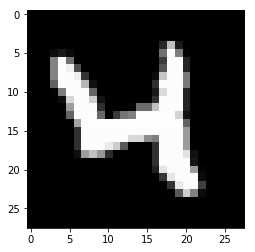

In [30]:
import matplotlib.pyplot as plt
random_img=train_dataset[20][0].numpy()*stddev_gray+mean_gray
plt.imshow(random_img.reshape(28,28),cmap='gray')

In [31]:
train_dataset[20][1]

4

In [0]:
batch_size=100
train_load=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_load=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [33]:
len(train_dataset)

60000

In [34]:
len(test_dataset)

10000

In [35]:
len(train_load)
#this means each batch size is 100

600

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    #same Padding=(filter_size-1)/2
    #same Padding=>inputsize=output_size=> (3-1)/2=1
    
    self.cnn1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
    #output size of each of the 8 fetaure maps:
    #[(input_size-filter_size+2(padding))/stride+1]=>(28-3+2)/1+1=>28
    self.batchnorm1=nn.BatchNorm2d(8)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=2)
    #output_size=28/2=14
    #Paading=>(5-1)/2=2
    self.cnn2=nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5,stride=1,padding=2)
    #output Size of each of the 32 feature maps[(14-5+2(2))/1+1]=14
    self.batchnorm2=nn.BatchNorm2d(32)
    #Flatten the 32 feature maps , each filter size is 7*7=>7*7*32=1568
    self.fc1=nn.Linear(1568,600)
    self.dropout=nn.Dropout(p=0.5)
    self.fc2=nn.Linear(600,10)
    
  def forward(self,x):
    out=self.cnn1(x)
    out=self.batchnorm1(out)
    out=self.relu(out)
    out=self.maxpool(out)
    out=self.cnn2(out)
    out=self.batchnorm2(out)
    out=self.relu(out)
    out=self.maxpool(out)
    #batch_size=100,if -1 pytorch will figure out itself
    out=out.view(-1,1568)
    
    out=self.fc1(out)
    out=self.relu(out)
    out=self.dropout(out)
    out=self.fc2(out)
    return out

In [0]:
model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()
loss_fn=nn.CrossEntropyLoss() 
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)  

In [38]:
iteration=0
correct=0
for i,(inputs,labels) in enumerate(train_load):
  if CUDA:
    inputs=inputs.cuda()
    labels=labels.cuda()
  print("for onre iteration ")
  print("Input shape",inputs.shape)
  print("labels shape",labels.shape)
  output=model(inputs)
  print("output shape",output.shape)
  _,predicted=torch.max(output,1)
  print("predicted shape",predicted.shape)
  print("Predicted tensor")
  print(predicted)
  correct+=(predicted==labels).sum()
  break
  

for onre iteration 
Input shape torch.Size([100, 1, 28, 28])
labels shape torch.Size([100])
output shape torch.Size([100, 10])
predicted shape torch.Size([100])
Predicted tensor
tensor([1, 6, 3, 8, 3, 8, 3, 6, 0, 1, 5, 3, 6, 5, 3, 3, 1, 8, 3, 5, 3, 4, 2, 0,
        9, 1, 3, 5, 3, 7, 3, 9, 6, 5, 8, 3, 3, 3, 3, 5, 6, 3, 5, 3, 3, 3, 3, 7,
        3, 5, 3, 6, 7, 3, 3, 4, 8, 5, 3, 3, 5, 3, 7, 3, 6, 5, 3, 7, 9, 3, 3, 3,
        3, 5, 3, 6, 3, 3, 9, 5, 3, 3, 3, 6, 3, 4, 5, 3, 3, 3, 9, 7, 4, 7, 3, 6,
        3, 5, 4, 3], device='cuda:0')


In [39]:
num_epochs=10
train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
for epoch in range(num_epochs):
  correct=0
  iterations=0
  iter_loss=0.0
  model.train()
  for i,(inputs,labels) in enumerate (train_load):
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    iter_loss+=loss.item()
    optimizer.zero_grad()
    #clearing gradient from previous iteration
    loss.backward()
    optimizer.step()
    _,predicted=torch.max(outputs,1)
    correct+=(predicted==labels).sum().item()
    iterations+=1
  train_loss.append(iter_loss/iterations)
  train_accuracy.append(100*correct/len(train_dataset))
  #testing
  testing_loss=0.0
  correct=0
  iterations=0
  model.eval()
  for i,(inputs,labels) in enumerate (test_load):
      if CUDA:
        inputs=inputs.cuda()
        labels=labels.cuda()
      outputs=model(inputs)
      loss=loss_fn(outputs,labels)
      testing_loss+=loss.item()
      
      _,predicted=torch.max(outputs,1)
      correct+=(predicted==labels).sum().item()
      iterations+=1
  test_loss.append(testing_loss/iterations)
  test_accuracy.append(100*correct/len(test_dataset))  
  print("Epoch{}/{},training loss:{:.3f},training accuracy:{:.3f},testing Loss:{:.3f},testing accuracy :{:.3f}".format(
  epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],test_loss[-1],test_accuracy[-1]))

Epoch1/10,training loss:0.297,training accuracy:91.783,testing Loss:0.053,testing accuracy :98.260
Epoch2/10,training loss:0.089,training accuracy:97.380,testing Loss:0.051,testing accuracy :98.330
Epoch3/10,training loss:0.072,training accuracy:97.920,testing Loss:0.046,testing accuracy :98.600
Epoch4/10,training loss:0.063,training accuracy:98.125,testing Loss:0.028,testing accuracy :99.130
Epoch5/10,training loss:0.059,training accuracy:98.308,testing Loss:0.036,testing accuracy :98.900
Epoch6/10,training loss:0.055,training accuracy:98.432,testing Loss:0.034,testing accuracy :99.060
Epoch7/10,training loss:0.056,training accuracy:98.390,testing Loss:0.043,testing accuracy :98.670
Epoch8/10,training loss:0.050,training accuracy:98.585,testing Loss:0.031,testing accuracy :99.110
Epoch9/10,training loss:0.050,training accuracy:98.538,testing Loss:0.056,testing accuracy :98.580
Epoch10/10,training loss:0.051,training accuracy:98.563,testing Loss:0.038,testing accuracy :99.020


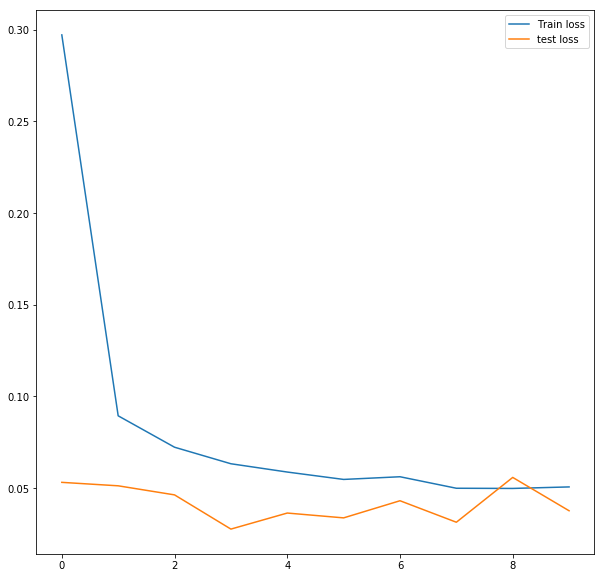

In [40]:
f=plt.figure(figsize=(10,10))
plt.plot(train_loss,label="Train loss")
plt.plot(test_loss,label="test loss")
plt.legend()
plt.show()

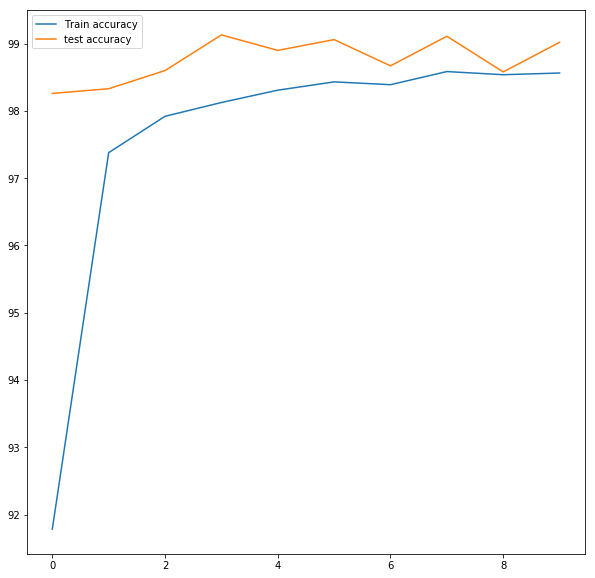

In [41]:
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy,label="Train accuracy")
plt.plot(test_accuracy,label="test accuracy")
plt.legend()
plt.show()